In [1392]:
print('Lets build the model :)')
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random
#In this modeling approach we are taking 3 previous and trying to predict the 4th word in the sequance

Lets build the model :)


In [1393]:
# reading the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [1394]:
len(words)

32033

In [1395]:
# building the mappings of characters to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [1396]:
#Building the train validation/dev and test
#the train data is used to train the  model the validation/dev set is used to tune the hyper parameters of the model
#and the test set is used to test the model
block_size = 3 #context length how many characters do we take to predict the next one
def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [1397]:
g = torch.Generator().manual_seed(219384384)
#creating a lookup table for the character embeddings
C = torch.randn((27,10), generator = g)
# Constructiong the hidden layer
#The number of inputs to this layer is going to be 3 * 10  because we have 10 dimensional embeddings and we have 3 of them
# and its up to us to decide how many neurons we want inside the layer here we are going with 200 of them
W1 = torch.randn(30,200, generator = g )
b1 = torch.randn(200, generator = g) 
W2 = torch.randn(200, 27, generator = g) #our second layer will take 200 inputs and 
b2 = torch.randn(27, generator = g)
parameters = [C,W1, b1, W2, b2]

In [1398]:
sum(p.nelement() for p in parameters) #tells us number of parameters in total

11897

In [1399]:
for p in parameters:
    p.requires_grad = True
#we do this because p.requires_grad is false by default but insted of treating these tensors as constant we want pytorch to treat them as variable, Variable which requires to have gradients

<function matplotlib.pyplot.show(close=None, block=None)>

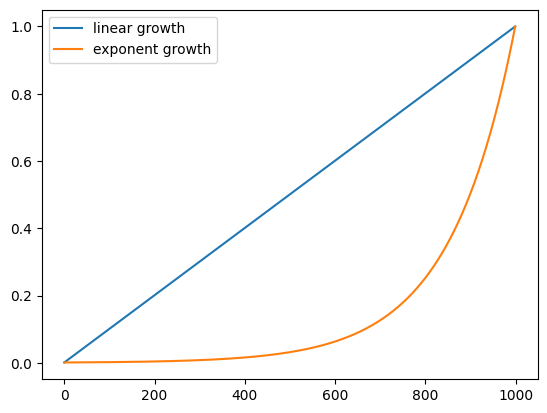

In [1400]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre #here we take the exponential distribution insted of the linear distribution because the learning rate is usually low and it will be difficult to find learning rate if we go linearly
plt.plot(torch.linspace(0.001, 1, 1000), label = 'linear growth')
plt.plot(lrs, label = 'exponent growth')
plt.legend()
plt.show #here is the visualization to understand that the plot in orange is exponentiated plot notice that it spends more time between 0.0 to 0.2 compared to the the blue line
#Now after creating the learning rate tensor we are going to run the optimization for 1000 steps and each time we will be changing the learning rate according to the iteration number and the tensor index
#Then we will record that data and plot the graph and that graph will give us the information on what learning rate to choose

In [1401]:
stepi  = []
lossi = []

In [1410]:
for i in range(300000):
    #creating a minibatch
    ix = torch.randint(0,Xtr.shape[0], (32,))
    #in the above line of code we are generating 32 random numbers between 0 and the number of examples(X.shape[0])
    # forward pass
    emb = C[Xtr[ix]] #the shape is (32,3,10)
    # in the code above we are only selecting 32 examples with the index ix randomly and calculating the loss based on those examples
    #and the implemeting gradient based on that loss this will speed up the training
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) #we are using tanh activation fn so the numbers in h will be -1 and 1 
    # We pass -1 to emb.view(), becuase we want pytorch to guess what what will be the right number for rows given we have already told it the number of columns are 30
    # here you can also use emb.reshape(-1,30) the difference is emb.view() will not use extra space it ensure that the emb tensor and and the new tensor that we create will use the same data so no memory wastag
    logits = h @ W2 + b2 #the shape is 32,27
    # implementing the loss function
    loss = F.cross_entropy(logits, Ytr[ix])  #implementing the categorical cross entropy using pytorch
    #we use pytorch here because large positive numbers when exponentiated causes the overflow which can be handled by subtracting the biggest number in the logits from each element row wise, and pytorch handles this operation internally
    # print(f'loss= {loss.item()} for iteration= {i+1}') 
    stepi.append(i)
    lossi.append(loss.log10().item()) # we are using the log of the loss because it is better for visualization
    # Implementing backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # param update
    if i <1000000:
        lr = 0.1
    elif i >100000 and i < 200000:
        lr = 0.01
    else:
        lr = 0.001
    for p in parameters:
        p.data -= lr * p.grad
        #IF THE Learning rate is very low the loss will be barely decreasing
        #if the learning rate is very high the loss will explode
print(f'loss= {loss.item()} for iteration= {i}')

loss= 2.0681955814361572 for iteration= 299999


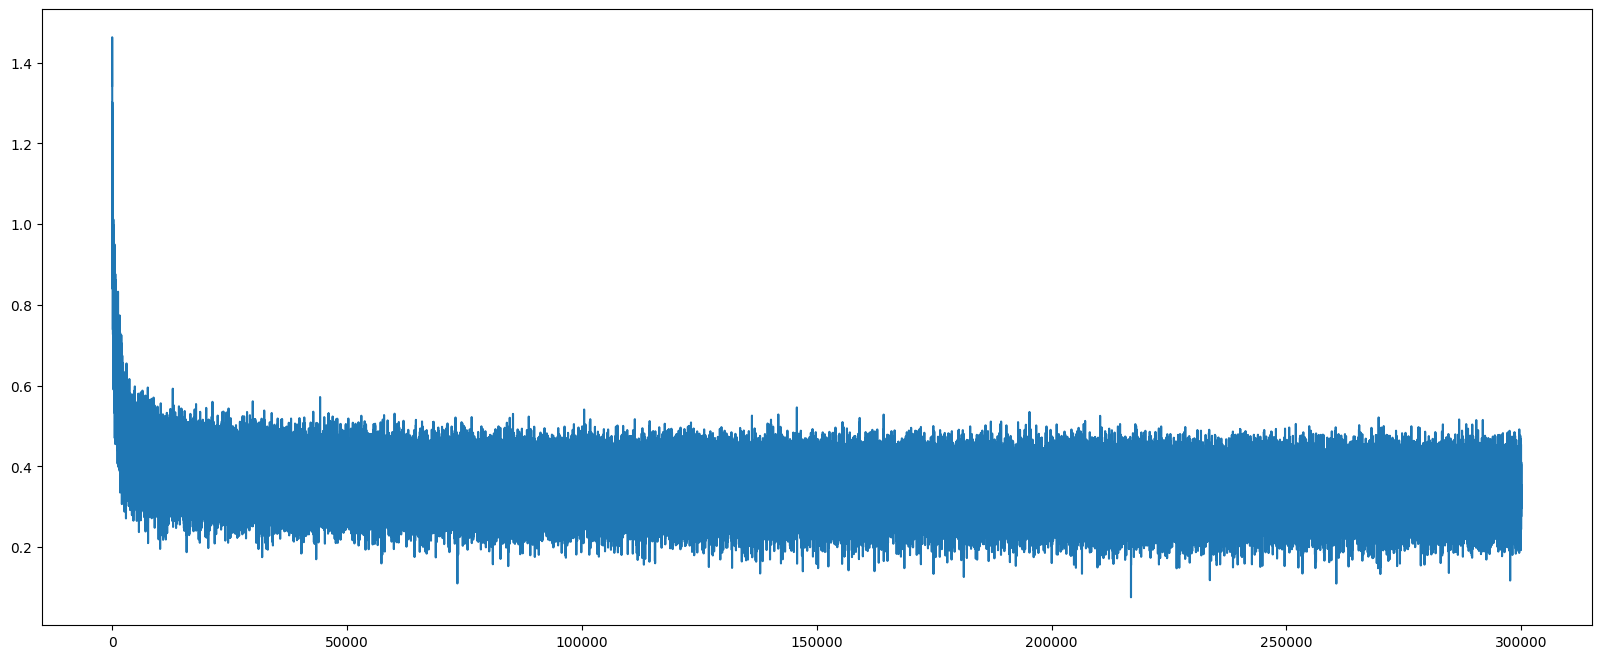

In [1403]:
plt.figure(figsize = (20,8))
plt.plot(stepi, lossi)
# you see a little bit of noise because we are computing batch sgd with 32 examples

In [1411]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 #the shape is 32,27
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.2698, grad_fn=<NllLossBackward0>)

In [1412]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 #the shape is 32,27
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.1910, grad_fn=<NllLossBackward0>)

In [1406]:
# we made the parameters bigger but there is no significant decrease in loss so we think that embeddings are the bottleneck so we will be increasing the size dimension of the embedding vector

In [1413]:
#code to generate inferance
g = torch.Generator().manual_seed(2387645786)
for _ in range(20):
    out = []
    context = [0]* block_size #initializing the context wit [. . .] 
    while True: 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g)
        context = context[1:] + [ix]
        out.append(ix.item())
        if ix == 0:
            break;
    print(''.join(itos[i] for i in out))

tion.
arra.
siyce.
asplon.
ana.
amari.
ana.
alver.
pypchari.
jaileigh.
yova.
rayline.
tavis.
valeiden.
trop.
lymarita.
emmerleth.
abius.
emilor.
paish.


In [ ]:
#The inferences above are actually a bit name like

In [1409]:
emb = C[Xte]
print (emb.shape) 
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 #the shape is 32,27
loss = F.cross_entropy(logits, Yte)
print(f'the final test loss after training is {loss}')

torch.Size([22866, 3, 10])
the final test loss after training is 2.261841297149658
